## POS tagging using modified Viterbi

### Data Preparation

In [164]:
#Importing libraries
import nltk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

In [165]:
# reading the Treebank tagged sentences
nltk.download('universal_tagset')
nltk.download('treebank')
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/faisal/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package treebank to /Users/faisal/nltk_data...
[nltk_data]   Package treebank is already up-to-date!


In [166]:
len(nltk_data)

3914

In [167]:
print(nltk_data[:10])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [168]:
# split data into train test with a 95% train and 5% test size
train_data, test_data = train_test_split(nltk_data,train_size=0.95, test_size=0.05, random_state=101)

In [169]:
print(len(train_data), len(test_data))

3718 196


In [170]:
# taking out the tagged words from the training and testing sets

train_tag = []
test_tag = []
for words in train_data:
    for word in words:
        train_tag.append(word)
        
for words in test_data:
    for word in words:
        test_tag.append(word)
        
        
print(len(train_tag))
print(len(test_tag))

95547
5129


In [171]:
# tagged words
print(train_tag[10:15])
print(test_tag[10:15])


[('Encouraging', 'VERB'), ('long-term', 'ADJ'), ('investing', 'NOUN'), ('.', '.'), ('Because', 'ADP')]
[('*', 'X'), ('phasing', 'VERB'), ('out', 'PRT'), ('John', 'NOUN'), ('Deere', 'NOUN')]


In [172]:
# check the number of words in the training set
words = {i for i, j in train_tag}
print(words)

{'*T*-55', 'pockets', '14.', 'bonds', 'efforts', '2.07', '396,000', 'piece', 'Mercantile', 'acknowledge', 'befell', 'change', 'Alysia', 'thrift', 'newspaper', 'Commerce', '1.9', 'summer', 'provisions', 'off-off', 'bonuses', 'counterattack', 'Winning', 'abortions', 'CERTIFICATES', 'limbo', 'Sol', 'theological', 'Sidak', 'Laura', 'unfunded', 'plaintiffs', 'best-selling', 'affiliates', 'receipts', 'denies', 'listed', 'revolves', 'disagree', '*-71', '*-46', 'insolvency', 'Austrian', 'regret', 'stellar', '228', 'hunted', 'films', 'contributed', 'wonder', 'Borge', 'Organizations', 'similarity', '992,000', 'Miller', 'finalized', 'established', 'privacy', 'judgments', 'life', 'Greenville', '28.36', 'DNA', 'infusion', 'defeat', 'Hopwood', 'Marcus', 'result', 'government', 'vacant', '226,570,380', '120-a-share', 'editing', 'contesting', 'mortgage-backed', 'boilers', 'violate', 'execute', 'firm', 'Competes', 'minutes', 'hopefully', 'contacts', '@', 'guarding', 'Monopolies', 'sales', 'spirits', 'T

In [173]:
print(len(words))

12100


In [174]:
# check the number of unique tags in training
unique_tags = {j for i,j in train_tag}
print(len(unique_tags))

12


In [175]:
print(unique_tags)

{'PRON', 'ADV', 'ADP', 'NUM', 'CONJ', 'DET', 'ADJ', 'PRT', 'NOUN', 'VERB', '.', 'X'}


In [176]:
# tokens - (from the lecture videos)
tokens = [pair[0] for pair in train_tag]
tokens[:10]

['Reliance',
 'confirmed',
 'the',
 'filing',
 'but',
 'would',
 "n't",
 'elaborate',
 '.',
 '*']

In [177]:
# vocabulary
V = set(tokens)
print(len(V))

12100


In [178]:
T = set([pair[1] for pair in train_tag])
print(len(T))

12


In [179]:
print(T)

{'PRON', 'ADV', 'ADP', 'NUM', 'CONJ', 'DET', 'ADJ', 'PRT', 'NOUN', 'VERB', '.', 'X'}


In [180]:
# computing P(w/t) and sotring in T x V matrix (from the video lectures)
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [181]:
# compute word given tag: Emission Probability (from the video lectures)
def word_given_tag(word, tag, train_bag = train_tag):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [182]:
# examples

# large
print("\n", "large")
print(word_given_tag('large', 'ADJ'))
print(word_given_tag('large', 'VERB'))
print(word_given_tag('large', 'NOUN'), "\n")

# will
print("\n", "will")
print(word_given_tag('will', 'VERB'))
print(word_given_tag('will', 'NOUN'))

# book
print("\n", "book")
print(word_given_tag('book', 'NOUN'))
print(word_given_tag('book', 'VERB'))



 large
(28, 6069)
(0, 12910)
(0, 27352) 


 will
(272, 12910)
(1, 27352)

 book
(7, 27352)
(1, 12910)


### Transition Probabilities

In [183]:
#compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability (source: video lectures)

def t2_given_t1(t2, t1, train_bag = train_tag):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [184]:
# examples
print(t2_given_t1(t2='NOUN', t1='ADJ'))
print(t2_given_t1('NOUN', 'DET'))
print(t2_given_t1('NOUN', 'VERB'))
print(t2_given_t1('.', 'NOUN'))
print(t2_given_t1('VERB', 'NOUN'))

(4246, 6069)
(5284, 8281)
(1421, 12910)
(6581, 27352)
(4039, 27352)


In [185]:
#Please note P(tag|start) is same as P(tag|'.') (source: video lectures)
print(t2_given_t1('DET', '.'))
print(t2_given_t1('VERB', '.'))
print(t2_given_t1('NOUN', '.'))

(1928, 11123)
(991, 11123)
(2472, 11123)


In [186]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

tags_matrix

array([[7.65696773e-03, 3.40735056e-02, 2.29709037e-02, 6.50842255e-03,
        5.35987737e-03, 9.95405857e-03, 7.31240436e-02, 1.30168451e-02,
        2.10949466e-01, 4.85451758e-01, 4.09647785e-02, 8.99693742e-02],
       [1.49055980e-02, 8.04902315e-02, 1.18582316e-01, 3.04736663e-02,
        6.95594586e-03, 6.98906928e-02, 1.29181847e-01, 1.42431268e-02,
        3.14673744e-02, 3.43491226e-01, 1.37131497e-01, 2.31864862e-02],
       [7.00310096e-02, 1.40062012e-02, 1.68929752e-02, 6.22260235e-02,
        9.62258084e-04, 3.24708641e-01, 1.07024483e-01, 1.38992839e-03,
        3.20966542e-01, 8.33956990e-03, 3.90249118e-02, 3.44274566e-02],
       [1.48898154e-03, 2.97796307e-03, 3.60333547e-02, 1.84931502e-01,
        1.36986300e-02, 3.27575929e-03, 3.42465751e-02, 2.65038721e-02,
        3.50208461e-01, 1.87611673e-02, 1.17331743e-01, 2.10541993e-01],
       [5.81125058e-02, 5.53231053e-02, 5.25337048e-02, 3.99814025e-02,
        4.64900048e-04, 1.21338911e-01, 1.18084610e-01, 4.64

In [187]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))
tags_df

,PRON,ADV,ADP,NUM,CONJ,DET,ADJ,PRT,NOUN,VERB,.,X
PRON,0.007657,0.034074,0.022971,0.006508,0.005360,0.009954,0.073124,0.013017,0.210949,0.485452,0.040965,0.089969
ADV,0.014906,0.080490,0.118582,0.030474,0.006956,0.069891,0.129182,0.014243,0.031467,0.343491,0.137131,0.023186
ADP,0.070031,0.014006,0.016893,0.062226,0.000962,0.324709,0.107024,0.001390,0.320967,0.008340,0.039025,0.034427
NUM,0.001489,0.002978,0.036033,0.184932,0.013699,0.003276,0.034247,0.026504,0.350208,0.018761,0.117332,0.210542
CONJ,0.058113,0.055323,0.052534,0.039981,0.000465,0.121339,0.118085,0.004649,0.349140,0.156671,0.034868,0.008833
DET,0.003744,0.012438,0.009540,0.022220,0.000483,0.005676,0.204323,0.000242,0.638087,0.039850,0.017993,0.045405
ADJ,0.000330,0.004778,0.078267,0.021256,0.016971,0.004943,0.066403,0.010710,0.699621,0.011699,0.063931,0.021091
PRT,0.017792,0.010214,0.020099,0.056672,0.002306,0.097858,0.083031,0.001647,0.247776,0.405272,0.043822,0.013509
NOUN,0.004607,0.017074,0.176514,0.009542,0.042666,0.012942,0.012248,0.043397,0.263564,0.147667,0.240604,0.029175
VERB,0.035786,0.081952,0.092022,0.022851,0.005577,0.134392,0.064988,0.030674,0.110070,0.169249,0.034934,0.217506


In [188]:

tags_df.loc['.', :]

PRON    0.066349
ADV     0.052324
ADP     0.091342
NUM     0.081003
CONJ    0.057538
DET     0.173335
ADJ     0.043963
PRT     0.002427
NOUN    0.222242
VERB    0.089095
.       0.093320
X       0.026971
Name: ., dtype: float32

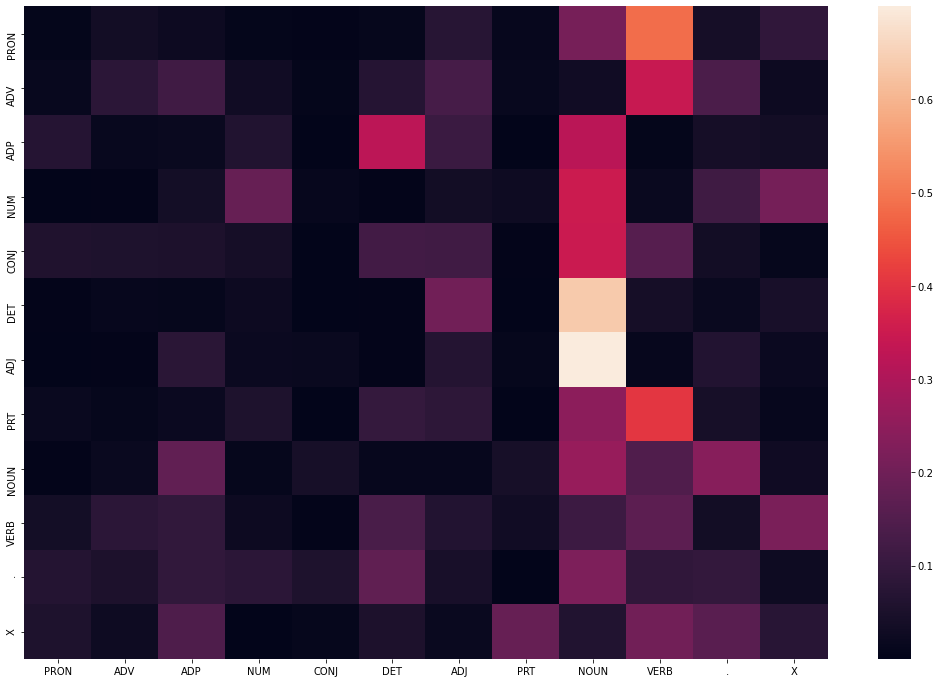

In [189]:
# heatmap of tags matrix
# T(i, j) indicates P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

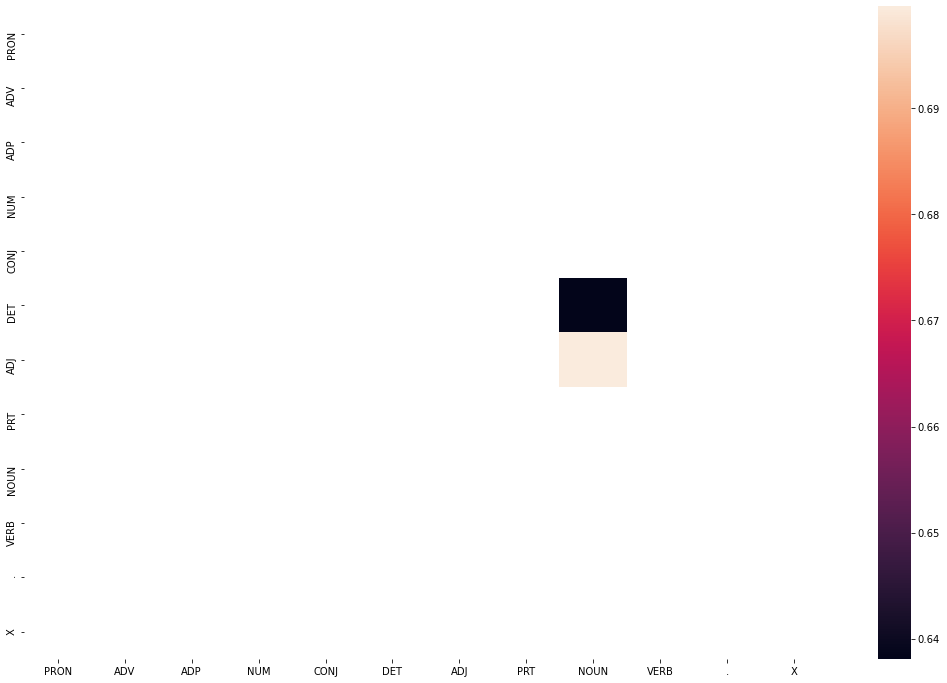

In [190]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

### Build the vanilla Viterbi based POS tagger

In [191]:
len(train_tag)

95547

In [192]:
# Viterbi Heuristic (lecture)
def Viterbi(words, train_bag = train_tag):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [193]:
# lets run the algorithm on a test dataset
import random
random.seed(101)

# choose random 5 sents
rndom = [random.randint(1,len(test_data)) for x in range(5)]

# list of sents
test_run = [test_data[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('This', 'DET'),
  ('species', 'NOUN'),
  ('of', 'ADP'),
  ('congressional', 'ADJ'),
  ('action', 'NOUN'),
  ('is', 'VERB'),
  ('predicated', 'VERB'),
  ('*-50', 'X'),
  ('on', 'ADP'),
  ('an', 'DET'),
  ('interpretation', 'NOUN'),
  ('of', 'ADP'),
  ('the', 'DET'),
  ('appropriations', 'NOUN'),
  ('clause', 'NOUN'),
  ('that', 'DET'),
  ('*T*-1', 'X'),
  ('is', 'VERB'),
  ('erroneous', 'ADJ'),
  ('and', 'CONJ'),
  ('unconstitutional', 'ADJ'),
  ('.', '.')],
 [('*-1', 'X'),
  ('Stung', 'VERB'),
  ('by', 'ADP'),
  ('charges', 'NOUN'),
  ('that', 'ADP'),
  ('their', 'PRON'),
  ('greed', 'NOUN'),
  ('is', 'VERB'),
  ('turning', 'VERB'),
  ('the', 'DET'),
  ('stock', 'NOUN'),
  ('market', 'NOUN'),
  ('into', 'ADP'),
  ('a', 'DET'),
  ('gigantic', 'ADJ'),
  ('crapshoot', 'NOUN'),
  (',', '.'),
  ('almost', 'ADV'),
  ('all', 'DET'),
  ('the', 'DET'),
  ('big', 'ADJ'),
  ('investment', 'NOUN'),
  ('banking', 'NOUN'),
  ('houses', 'NOUN'),
  ('have', 'VERB'),
  ('abandoned', 'VERB'),
  ('ind

In [194]:
# tagging the test sentences
import time
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [195]:
print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  45.51268696784973
[('This', 'DET'), ('species', 'PRON'), ('of', 'ADP'), ('congressional', 'ADJ'), ('action', 'NOUN'), ('is', 'VERB'), ('predicated', 'PRON'), ('*-50', 'X'), ('on', 'ADP'), ('an', 'DET'), ('interpretation', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('appropriations', 'NOUN'), ('clause', 'NOUN'), ('that', 'ADP'), ('*T*-1', 'X'), ('is', 'VERB'), ('erroneous', 'PRON'), ('and', 'CONJ'), ('unconstitutional', 'ADJ'), ('.', '.'), ('*-1', 'X'), ('Stung', 'VERB'), ('by', 'ADP'), ('charges', 'NOUN'), ('that', 'ADP'), ('their', 'PRON'), ('greed', 'NOUN'), ('is', 'VERB'), ('turning', 'VERB'), ('the', 'DET'), ('stock', 'NOUN'), ('market', 'NOUN'), ('into', 'ADP'), ('a', 'DET'), ('gigantic', 'PRON'), ('crapshoot', 'PRON'), (',', '.'), ('almost', 'ADV'), ('all', 'DET'), ('the', 'DET'), ('big', 'ADJ'), ('investment', 'NOUN'), ('banking', 'NOUN'), ('houses', 'NOUN'), ('have', 'VERB'), ('abandoned', 'VERB'), ('index', 'NOUN'), ('arbitrage', 'NOUN'), (',', '.'), ('a',

In [196]:
# checking the accuracy of the model
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

accuracy = len(check)/len(tagged_seq)
print('Accuracy: ',accuracy*100)

Accuracy:  89.41176470588236


In [197]:
# find the words incorrectly tagged
incorrect_tagged_cases =[j for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0] != j[1]]
len(incorrect_tagged_cases)

18

In [198]:
incorrect_tagged_cases

[(('species', 'PRON'), ('species', 'NOUN')),
 (('predicated', 'PRON'), ('predicated', 'VERB')),
 (('that', 'ADP'), ('that', 'DET')),
 (('erroneous', 'PRON'), ('erroneous', 'ADJ')),
 (('gigantic', 'PRON'), ('gigantic', 'ADJ')),
 (('crapshoot', 'PRON'), ('crapshoot', 'NOUN')),
 (('Pittsburgh', 'PRON'), ('Pittsburgh', 'NOUN')),
 (('Advanced', 'PRON'), ('Advanced', 'NOUN')),
 (('executes', 'PRON'), ('executes', 'VERB')),
 (('planting', 'PRON'), ('planting', 'NOUN')),
 (('orange', 'PRON'), ('orange', 'ADJ')),
 (('trees', 'PRON'), ('trees', 'NOUN')),
 (('that', 'ADP'), ('that', 'DET')),
 (('cane', 'PRON'), ('cane', 'NOUN')),
 (('more', 'ADV'), ('more', 'ADJ')),
 (('Andrea', 'PRON'), ('Andrea', 'NOUN')),
 (('American', 'ADJ'), ('American', 'NOUN')),
 (('tutorials', 'PRON'), ('tutorials', 'NOUN'))]

### Solve the problem of unknown words

### Lexicon and Rule-Based approach for POS Tagging

In [199]:
# approach 1
# Modified Viterbi Heuristic- Approach I
def Viterbi1(words, train_bag = train_tag):
    state = []
    
    # Take the list of unique tags present in the corpus
    T = sorted(list(set([pair[1] for pair in train_bag])))
    V = [i[0] for i in train_bag]
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        
        for tag in T:
            if key == 0: #first word has key=0
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            
            # modification to the original vanilla viterbi algorithm. 
            # Vocab contains the list of unique words in training dataset
            if word not in V: 
                state_probability = transition_p
            else:
                state_probability = emission_p * transition_p
                
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [200]:
# tagging the test sentences
import time
start = time.time()
tagged_seq = Viterbi1(test_tagged_words)
end = time.time()
difference = end-start

In [201]:
print("Time taken in seconds: ", difference)

Time taken in seconds:  45.09267997741699


In [202]:
print("time take in this approach is slightly longer than the initial approach")

time take in this approach is slightly longer than the initial approach


In [203]:
# accuracy 
# checking the accuracy of the model
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

accuracy = len(check)/len(tagged_seq)
print('Accuracy: ',accuracy*100)

Accuracy:  92.3529411764706


### as we can see this models accuracy is slightly higher than the previous model's which was 89.4%

In [204]:
#incorrect tagged cases
# find the words incorrectly tagged
incorrect_tagged_cases1 =[j for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0] != j[1]]
len(incorrect_tagged_cases1)

13

### this time we have only 13 incorrectly tagged cases as to 18 before

In [205]:
print(incorrect_tagged_cases1)

[(('predicated', 'X'), ('predicated', 'VERB')), (('that', 'ADP'), ('that', 'DET')), (('erroneous', 'X'), ('erroneous', 'ADJ')), (('gigantic', 'NOUN'), ('gigantic', 'ADJ')), (('Pittsburgh', 'VERB'), ('Pittsburgh', 'NOUN')), (('executes', 'NOUN'), ('executes', 'VERB')), (('planting', 'VERB'), ('planting', 'NOUN')), (('orange', 'DET'), ('orange', 'ADJ')), (('that', 'ADP'), ('that', 'DET')), (('cane', 'DET'), ('cane', 'NOUN')), (('more', 'ADV'), ('more', 'ADJ')), (('Andrea', 'VERB'), ('Andrea', 'NOUN')), (('American', 'ADJ'), ('American', 'NOUN'))]


In [225]:
# source StackOverflow
patterns = [
    (r'^([0-9]|[aA-zZ])+\-([0-9]|[aA-zZ])*$','ADJ'),
    (r'.*able$', 'ADJ'),                     
    (r'.*ful$', 'ADJ'),                      
    (r'.*ous$', 'ADJ'),                      
    
    (r'.*\'s$', 'NOUN'),                    
    (r'.*s$', 'NOUN'),                      
    (r'^[aA-zZ].*[0-9]+','NOUN'),           
    (r'.*ers$', 'NOUN'),                     
    (r'.*ment$', 'NOUN'),                   
    (r'.*town$', 'NOUN'),                      
    (r'.*ness$', 'NOUN'),                   
    (r'^[A-Z]+([a-z]{1,2})?\.?$','NOUN'),    
    
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'),       
    (r'.*ly$', 'ADV'),                       
    
    (r'^[0-9]+(.[0-9]+)?$', 'NUM'),                
    (r'^(0|([*|-|$].*))','X'),                 
    
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'),   
    (r'.*', 'NOUN')  
    ]
rule_based_tagger = nltk.RegexpTagger(patterns)

In [226]:
# approach 2
# Modified Viterbi Heuristic- Approach 2
def Viterbi2(words, train_bag = train_tag):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    tag_probability = []
    total_tag = len([tag for word,tag in train_tag])
    for t in unique_tags:
        each_tag = [tag for word,tag in train_tag if tag==t]
        tag_probability.append((t,len(each_tag)/total_tag))

    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        p_transition =[] # for storing transition probabilities
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
            # find POS probability
            tag_p = [pair[1] for pair in tag_probability if pair[0]==tag ]
            
            # calculate the transition prob weighted by tag occurance probability.
            transition_p = tag_p[0]*transition_p
            p_transition.append(transition_p)
            
        pmax = max(p)
        state_max = rule_based_tagger.tag([word])[0][1] 
        
      
        # getting state for which probability is maximum
        if(pmax==0):
            state_max = rule_based_tagger.tag([word])[0][1] # assign based on rule based tagger
            
            # if unknown word does not satisfy any rule, find the tag with maximum transition probability
            if state_max == 'NN':
                pmax = max(p_transition)
                state_max = T[p_transition.index(pmax)]                 
                
        else:
             if state_max != 'X':
                # getting state for which probability is maximum
                state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

In [227]:
# tagging the test sentences
import time
start = time.time()
tagged_seq = Viterbi2(test_tagged_words)
end = time.time()
difference = end-start

In [228]:
print("Time taken in seconds: ", difference)

Time taken in seconds:  42.877297163009644


In [229]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print('Modified Viterbi_2 Accuracy: ',accuracy*100)

Modified Viterbi_2 Accuracy:  94.70588235294117


### this second approach of the algorithm sees to perform better than before, as it was 92.35% now its 93.53%

In [211]:
# Lets check for incorrectly tagged words
incorrect_tagged_cases2 =[j for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0] != j[1]]
len(incorrect_tagged_cases2)

11

### this time we have only 11 incorrectly tagged cases as to 13 before

In [212]:
print(incorrect_tagged_cases2)

[(('species', 'VERB'), ('species', 'NOUN')), (('that', 'ADP'), ('that', 'DET')), (('erroneous', 'NOUN'), ('erroneous', 'ADJ')), (('gigantic', 'NOUN'), ('gigantic', 'ADJ')), (('Advanced', 'VERB'), ('Advanced', 'NOUN')), (('planting', 'VERB'), ('planting', 'NOUN')), (('orange', 'NOUN'), ('orange', 'ADJ')), (('trees', 'VERB'), ('trees', 'NOUN')), (('that', 'ADP'), ('that', 'DET')), (('more', 'ADV'), ('more', 'ADJ')), (('American', 'ADJ'), ('American', 'NOUN'))]


#### Evaluating tagging accuracy most of the evaluation is done above

In [213]:
# # well evaulate the tagging on the sample sentences
# f = open('sample_sentences.txt')
# text = f.read()
# sample_line = text.splitlines()
# f.close()


In [214]:
# sample_line = sample_line[:-3]
# sample_line

In [215]:
# words = [word for sent in sample_line for word in sent.split()]

In [216]:
# word

In [217]:
sample_test_sent = ['Android is a mobile operating system developed by Google.',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.',
 'Show me the cheapest round trips from Dallas to Atlanta', 'I would like to see flights from Denver to Philadelphia.',
'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.',
'NASA invited social media users to experience the launch of ICESAT-2 Satellite.']

In [218]:
words = [word for sent in sample_test_sent for word in sent.split()]

In [219]:
# tagging the test sentences on the original algorithm
start = time.time()
sample_tagged_seq = Viterbi(words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

Time taken in seconds:  42.16979622840881


In [220]:
sample_tagged_seq

[('Android', 'PRON'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google.', 'PRON'),
 ('Android', 'PRON'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'PRON'),
 ('worldwide', 'PRON'),
 ('on', 'ADP'),
 ('smartphones', 'PRON'),
 ('since', 'ADP'),
 ('2011', 'PRON'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013.', 'PRON'),
 ('Google', 'PRON'),
 ('and', 'CONJ'),
 ('Twitter', 'PRON'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'PRON'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'PRON'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ("Twitter's", 'PRON'),
 ('firehose.', 'PRON'),
 ('Twitter', 'PRON'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'PRON'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('service', 'NOUN'),
 ('on', 'ADP'),
 ('which', 'D

#### modified Viterbi algorithm

In [221]:
# tagging the test sentences on the modified algorithm
start = time.time()
sample_tagged_seq = Viterbi2(words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

Time taken in seconds:  44.88323712348938


In [222]:
sample_tagged_seq

[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google.', 'NOUN'),
 ('Android', 'NOUN'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('on', 'ADP'),
 ('smartphones', 'VERB'),
 ('since', 'ADP'),
 ('2011', 'NUM'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013.', 'NOUN'),
 ('Google', 'NOUN'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'NUM'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'NOUN'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ("Twitter's", 'NOUN'),
 ('firehose.', 'NOUN'),
 ('Twitter', 'NOUN'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'NOUN'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('service', 'NOUN'),
 ('on', 'ADP'),
 ('which', 'DET

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

##### The accuracy of the vanilla Viterbi Algorithm was: 89.4%

##### The Accuracy of the first Modified Viterbi Lexicon Tagger Algorithm is: 92.33%

##### The Accuracy of the second Modified Viterbi Rule-Based Algorithm is: 94.7%

##### That is about 5.3% improvement over the vanilla algorithm

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

- Android: is correctly tagged as Noun, the vanilla algorithm tagged it as a PRON
- Google: is correctly tagged as Noun, the vanilla algorithm tagged it as a PRON
- 2011: is correctly tagged as NUM, the vanilla algorithm tagged it as a PRON
- Twitter: is correctly tagged as Noun, the vanilla algorithm tagged it as a PRON
- 2015, 2018: are correctly tagged as NUM, the vanilla algorithm tagged it as a PRON
- firehose: is correctly tagged as Noun, the vanilla algorithm tagged it as a PRON
- domineering: is correctly tagged as ADJ, the vanilla algorithm tagged it as a PRON
- contested: is correctly tagged as Verb, the vanilla algorithm tagged it as a PRON
- years: is correctly tagged as Noun, the vanilla algorithm tagged it as a PRON
- arriving: is correctly tagged as Verb, the vanilla algorithm tagged it as a PRON
- species: is correctly tagged as noun the vanilla algorithm tagged it as a PRON
##### Seems like the vanilla algorithm tags the words it doesnt understand as PRON